In [1]:
import rospy
from sensor_msgs.msg import Image
from cv_bridge import CvBridge
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from std_msgs.msg import Float64
from dynamixel_sdk import *
import datetime
import threading
import serial
import re
import pandas as pd
import glob


In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>div.output_scroll { height: 44em; }</style>"))

/tmp/ipykernel_40781/2284580335.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [3]:
%%javascript

window.scroll_flag = true
window.scroll_exit = false
window.scroll_delay = 100

$(".output_scroll").each(function() {
    $(this)[0].scrollTop = $(this)[0].scrollHeight;
});

function callScrollToBottom() {
    setTimeout(scrollToBottom, window.scroll_delay);
}

function scrollToBottom() {
    if (window.scroll_exit) {
        return;
    }
    if (!window.scroll_flag) {
        callScrollToBottom();
        return;
    };
    
    $(".output_scroll").each(function() {
        if (!$(this).attr('scroll_checkbox')){
            window.scroll_flag = true;
            $(this).attr('scroll_checkbox',true);
            var div = document.createElement('div');
            var checkbox = document.createElement('input');
            checkbox.type = "checkbox";
            checkbox.onclick = function(){window.scroll_flag = checkbox.checked}
            checkbox.checked = "checked"
            div.append("Auto-Scroll-To-Bottom: ");
            div.append(checkbox);
            $(this).parent().before(div);
        }
        
        $(this)[0].scrollTop = $(this)[0].scrollHeight;
    });
    callScrollToBottom();
}
scrollToBottom();

<IPython.core.display.Javascript object>

In [4]:
class Dynamixel_motor:
    def __init__(self, dxl_id, baudrate, device_name):
        self.dxl_id = dxl_id
        self.baudrate = baudrate
        self.device_name = device_name
        self.protocol_version = 2.0

        # Initialize PortHandler instance
        # Set the port path
        # Get methods and members of PortHandlerLinux or PortHandlerWindows
        self.portHandler = PortHandler(self.device_name)

        # Initialize PacketHandler instance
        # Set the protocol version
        # Get methods and members of Protocol1PacketHandler or Protocol2PacketHandler
        self.packetHandler = PacketHandler(self.protocol_version)

        # Open port
        if self.portHandler.openPort():
            print("Succeeded to open the port")
        else:
            print("Failed to open the port")
            print("Press any key to terminate...")
            self.close_port()

        # Set port baudrate
        if self.portHandler.setBaudRate(self.baudrate):
            print("Succeeded to change the baudrate")
        else:
            print("Failed to change the baudrate")
            print("Press any key to terminate...")
            self.close_port()

    def __del__(self):
        print('Destructor called.')
        self.portHandler.closePort()

    def close_port(self):
        self.torque_disable()
        self.portHandler.closePort()
        print('closing port.')

    def ping_motor(self):

        # Try to ping the Dynamixel
        # Get Dynamixel model number
        dxl_model_number, dxl_comm_result, dxl_error = self.packetHandler.ping(self.portHandler, self.dxl_id)
        print(f"dxl_model_number is: {dxl_model_number}")
        print(f"dxl_comm_result is: {dxl_comm_result}")
        print(f"dxl_error is: {dxl_error}")
        print(f"COMM_SUCCESS is {COMM_SUCCESS}")
        if dxl_comm_result != COMM_SUCCESS:
            print("statement 0")
            print("%s" % self.packetHandler.getTxRxResult(dxl_comm_result))
            self.close_port()
        elif dxl_error != 0:
            print("statement 1")
            print("%s" % self.packetHandler.getRxPacketError(dxl_error))
            self.close_port()
        else:
            print("statement 2")
            print("[ID:%03d] ping Succeeded. Dynamixel model number : %d" % (self.dxl_id, dxl_model_number))

    def torque_enable(self):
        TORQUE_ENABLE_REG = 64
        TORQUE_ENABLE = 1
        result, error = self.packetHandler.write4ByteTxRx(self.portHandler, self.dxl_id, TORQUE_ENABLE_REG, TORQUE_ENABLE)
        return

    def torque_disable(self):
        TORQUE_ENABLE_REG = 64
        TORQUE_ENABLE = 0
        result, error = self.packetHandler.write4ByteTxRx(self.portHandler, self.dxl_id, TORQUE_ENABLE_REG, TORQUE_ENABLE)
        return

    def read_operation_mode(self):
        OPERATING_MODE_REG = 11
        data, result, error = self.packetHandler.read1ByteTxRx(self.portHandler, self.dxl_id, OPERATING_MODE_REG)
        print(f"data is: {data}")
        print(f"result is: {result}")
        print(f"error is: {error}")
        return data

    def set_current_position_mode(self):
        OPERATING_MODE_REG = 11
        OPERATION_MODE = 5
        result, error = self.packetHandler.write1ByteTxRx(self.portHandler, self.dxl_id, OPERATING_MODE_REG, OPERATION_MODE)
        return

    def set_goal_current(self, GOAL_CURRENT):
        GOAL_CURRENT_REG = 102
        result, error = self.packetHandler.write2ByteTxRx(self.portHandler, self.dxl_id, GOAL_CURRENT_REG, GOAL_CURRENT)
        return

    def read_present_position(self):
        PRESENT_POSITION_REG = 132
        PRESENT_POSITION, result, error = self.packetHandler.read4ByteTxRx(self.portHandler, self.dxl_id, PRESENT_POSITION_REG)
        return PRESENT_POSITION

    def set_goal_position(self, GOAL_POSITION):
        GOAL_POSITION_REG = 116
        result, error = self.packetHandler.write4ByteTxRx(self.portHandler, self.dxl_id, GOAL_POSITION_REG, GOAL_POSITION)
        return

    def read_present_current(self):
        PRESENT_CURRENT_REG = 126
        PRESENT_CURRENT, result, error = self.packetHandler.read2ByteTxRx(self.portHandler, self.dxl_id, PRESENT_CURRENT_REG)
        return PRESENT_CURRENT


Succeeded to open the port
Succeeded to change the baudrate
data is: 5
result is: 0
error is: 0
Enter something: 
[INFO] [1676620345.021469]: Timing images
b''
b'000.0,000.0,0000.1,0000.0\r\n009.4,006.5,0'
Data number 0
['000.0', '000.0', '0000.1', '0000.0', '009.4', '006.5']
[INFO] [1676620349.287960]: Image received...


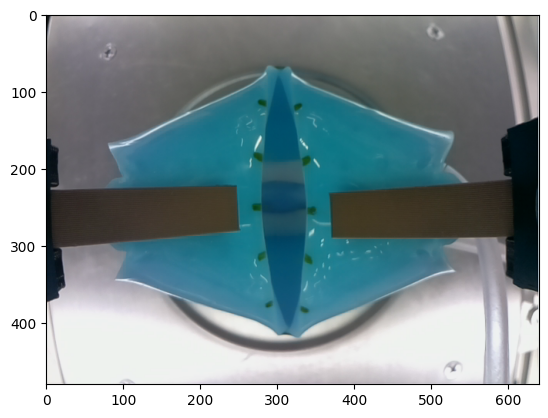

Enter something: 
b'146.1,0144.9\r\n000.0,000.0,0000.2,0000.0\r'
b'\n008.0,005.2,0144.5,0147.0\r\n'
Data number 1
['008.0', '005.2', '0144.5', '0147.0']
[INFO] [1676620358.300681]: Image received...


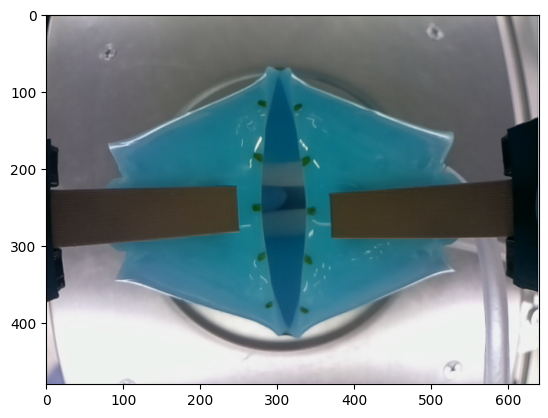

Enter something: 
b'000.0,000.0,0000.8,0000.5\r\n'
b'008.7,007.5,0151.7,0150.7\r\n'
Data number 2
['008.7', '007.5', '0151.7', '0150.7']
[INFO] [1676620366.307892]: Image received...


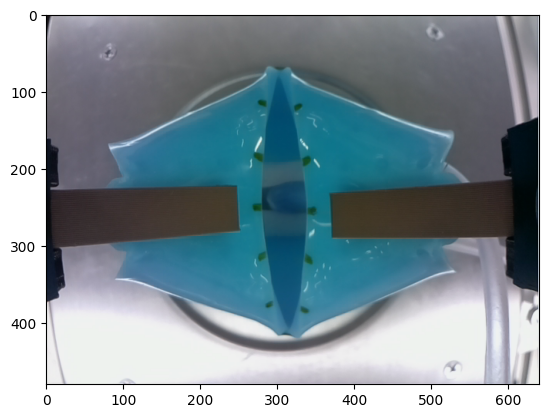

Enter something: 
b'000.0,000.0,0000.3,0000.2\r\n'
[INFO] [1676620377.296097]: Image received...


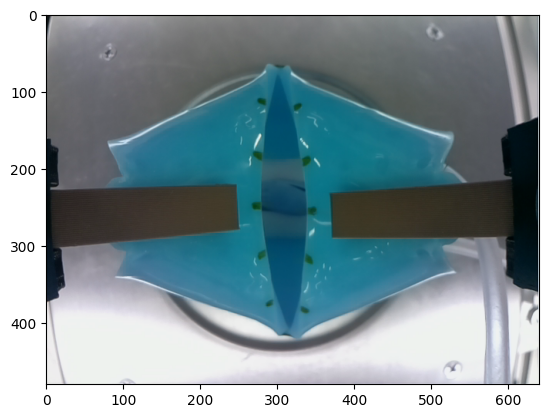

b'011.7,010.1,0152.3,0152.0\r\n'
Data number 4
['011.7', '010.1', '0152.3', '0152.0']
Enter something: 
b'000.0,000.0,0000.9,0000.8\r\n'
[INFO] [1676620384.292459]: Image received...


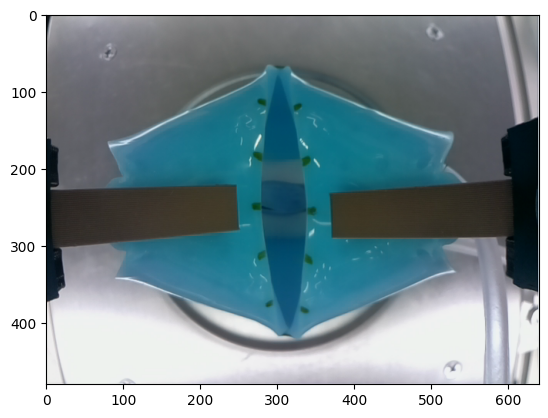

b'010.4,009.0,0160.1,0161.6\r\n'
Data number 5
['010.4', '009.0', '0160.1', '0161.6']
Enter something: 
b'000.0,000.0,0000.4,0000.4\r\n'
b'019.7,015.1,0161.3,0160.3\r\n'
Data number 5
['019.7', '015.1', '0161.3', '0160.3']
[INFO] [1676620394.299590]: Image received...


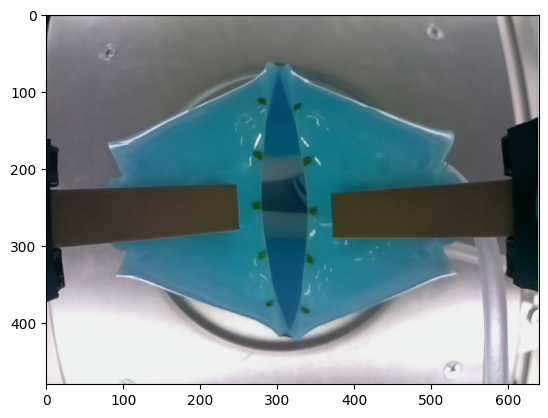

Enter something: 
b'000.0,000.0,0000.5,0000.5\r\n'
b'031.3,027.5,0180.5,0179.4\r\n'
Data number 6
['031.3', '027.5', '0180.5', '0179.4']
[INFO] [1676620402.293438]: Image received...


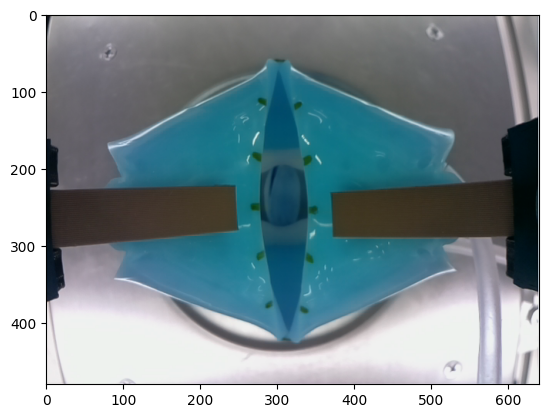

Enter something: 
b'000.0,000.0,0001.0,0001.0\r\n'
[INFO] [1676620409.292196]: Image received...
b'011.9,010.0,0162.2,0161.1\r\n'
Data number 8
['011.9', '010.0', '0162.2', '0161.1']


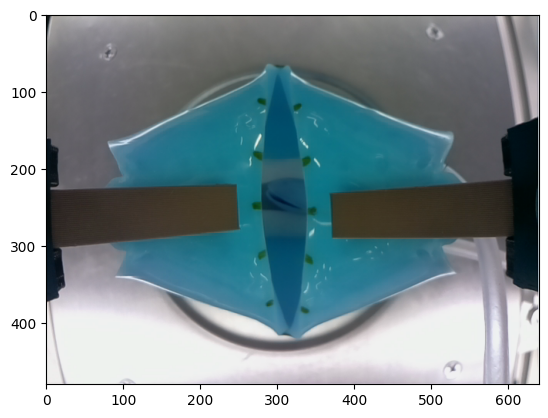

Enter something: 
b'000.0,000.0,0000.4,0000.5\r\n'
[INFO] [1676620417.294836]: Image received...


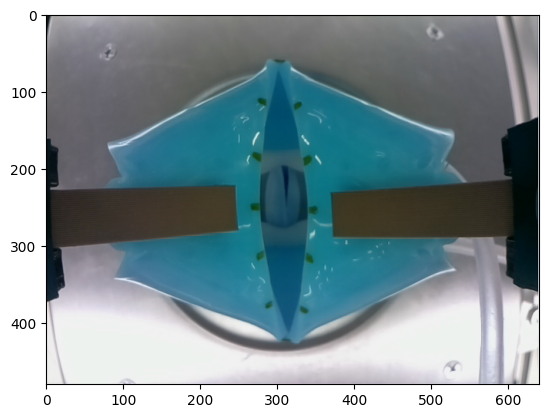

b'030.4,027.1,0180.1,0179.2\r\n'
Data number 9
['030.4', '027.1', '0180.1', '0179.2']
Enter something: 
b'000.0,000.0,0000.8,0000.9\r\n'
[INFO] [1676620424.291379]: Image received...


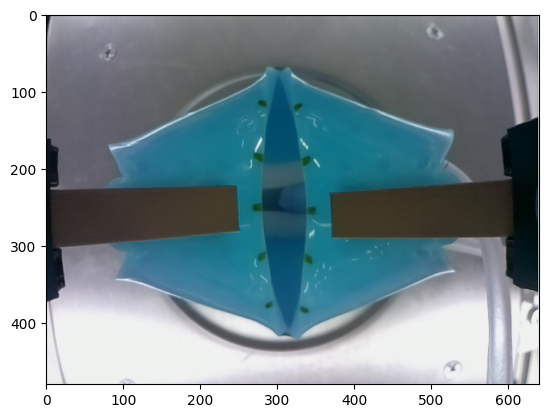

b'007.8,008.6,0156.6,0155.2\r\n'
Data number 10
['007.8', '008.6', '0156.6', '0155.2']


In [5]:
class Nodo(object):
    def __init__(self, dxl_motor):
        
        self.input_thread = threading.Thread(target=self.get_input)
        self.input_thread.daemon = True
        self.input_thread.start()
        
        self.image_array = []
        self.pressure_reading_1 = []
        self.pressure_reading_2 = []
        self.force_reading_1 = []
        self.force_reading_2 = []
        
        self.command = '0'
        self.take_photo = '0'
        self.dxl_motor = dxl_motor
        self.initialise_motor()
        
        self.ser = serial.Serial('/dev/ttyACM0', 57600, timeout=1)
        self.initialise_arduino()
        
        self.br = CvBridge()
        # Node cycle rate (in Hz).
        self.loop_rate = rospy.Rate(1)

        # Publishers
        self.pub = rospy.Publisher('number_command', Float64, queue_size=10)

        # Subscribers
        rospy.Subscriber("/image_capture",Image,self.callback)
    
    def initialise_arduino(self):
        time.sleep(2) # wait for the arduino to initialise
        self.ser.read(200) # clear the serial buffer
    
    def untare_read_arduino(self):
        # 0: clear tare and read, 1: tare and read, 2: read
        self.ser.write(b'0')
        time.sleep(0.1)
        return self.ser.read(40)
    
    def tare_read_arduino(self):
        # 0: clear tare and read, 1: tare and read, 2: read
        self.ser.write(b'1')
        time.sleep(0.1)
        return self.ser.read(40)
    
    def read_arduino(self):
        # 0: clear tare and read, 1: tare and read, 2: read
        self.ser.write(b'2')
        time.sleep(0.1)
        return self.ser.read(40)
    
    def initialise_motor(self):
        self.dxl_motor.set_current_position_mode()
        self.dxl_motor.read_operation_mode()
        self.dxl_motor.set_goal_current(50)
        
    def move_jaw(self, position):
        self.dxl_motor.torque_enable()
#         print(f"current position is {self.dxl_motor.read_present_position()}")
        self.dxl_motor.set_goal_position(position)
    
    def disable_jaw(self):
        self.dxl_motor.torque_disable()
    
    def get_input(self):
        while True:
            self.command = input("Enter something: ")
            time.sleep(1)
    
    def callback(self, msg):
        rospy.loginfo('Image received...')
        self.image = self.br.imgmsg_to_cv2(msg)
        self.image_array.append(self.image)
        plt.imshow(self.image)
        plt.show()
    
    def store_arduino_data(self, data):
        text = re.findall('\d+\.\d+', data.decode("utf-8"))
        print(text)
        self.pressure_reading_1.append(float(text[0]))
        self.pressure_reading_2.append(float(text[1]))
        self.force_reading_1.append(float(text[2]))
        self.force_reading_2.append(float(text[3]))
    
    def save_data(self):
        image_name = []
        directory = './Grasp_dataset_2/Grasp_dataset_pistachio/'
        
        start_number = 50
        
        for i in range(0, len(self.image_array)):
            image_name.append('Gimage' + str(i+start_number).zfill(3) + '.jpg')
            cv2.imwrite(directory +'Gimage' + str(i+start_number).zfill(3) + '.jpg', my_node.image_array[i])
        
        header = ['image_name', 'pressure_reading_1', 'pressure_reading_2', 'force_reading_1', 'force_reading_2', 'label']
        grasp_df = pd.concat([pd.Series(image_name), pd.Series(self.pressure_reading_1), pd.Series(self.pressure_reading_2), pd.Series(self.force_reading_1), pd.Series(self.force_reading_2), pd.Series(np.repeat('pistachio', len(self.image_array)))], axis=1, keys=header)
        
        combined_df_set = pd.concat([combined_df_set, grasp_df], axis=0)
        
        combined_df_set.to_csv(directory + 'Grasp_dataset_pistachio.csv', index=False)
        
    def start(self):
        rospy.loginfo("Timing images")
#         rospy.spin()
        while not rospy.is_shutdown():
            
            if self.command == '':
#                 rospy.loginfo('publishing number and closing jaw')
                print(self.tare_read_arduino())
                time.sleep(0.5)
                self.move_jaw(1500)
                time.sleep(2)
                self.pub.publish(5201314)
                data = self.read_arduino()
                print(data)
                print('Data number ' + str(len(self.image_array)))
                self.store_arduino_data(data)
                time.sleep(0.5)
                self.command = '2'
                
            elif self.command == '2':
#                 rospy.loginfo('publishing number and opening jaw')
                self.move_jaw(200)
#                 print(self.untare_read_arduino())
            elif self.command == '3':
#                 rospy.loginfo('publishing number and disabling jaw')
                self.disable_jaw()
            
            self.loop_rate.sleep()

if __name__ == '__main__':
    rospy.init_node("command_publisher", anonymous=True)
    dxl_motor = Dynamixel_motor(1, 57600, '/dev/ttyUSB0')
    my_node = Nodo(dxl_motor)
    my_node.start()

In [6]:
my_node.save_data()